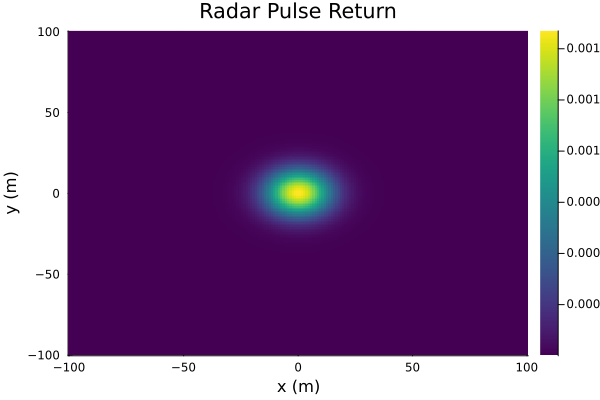

In [1]:
using Plots
using Distributions
using StaticArrays

# Define grid
x = LinRange(-100.0, 100.0, 200)
y = LinRange(-100.0, 100.0, 200)

# Simulate a simple 2D radar return with a target at center
heat = [pdf(MvNormal([0, 0], 10), [xi, yi]) for xi in x, yi in y]

# Plot heatmap of simulated pulse return
heatmap(x, y, heat, c=:viridis, xlabel="x (m)", ylabel="y (m)", title="Radar Pulse Return")


In [6]:
using StaticArrays
using LinearAlgebra
using Distributions
using Plots

# Abstract transmitter type
abstract type AbstractTransmitter end

# PointTransmitter
struct PointTransmitter <: AbstractTransmitter
    position::SVector{2, Float64}
    frequency::Float64
    power::Float64
    tx_time::Float64
    pulse_width::Float64
    steering_angle::Float64
    beamwidth::Float64
    is_isotropic::Bool
end

# Reflector
mutable struct Reflector
    position::SVector{2, Float64}
    pulse_width::Float64
    reflection_gain::Float64
    has_reflected::Bool
end

# Receiver
mutable struct Receiver
    position::SVector{2, Float64}
    received_power::Vector{Float64}
end

# Radar environment
mutable struct RadarEnvironment
    grid_x::Vector{Float64}
    grid_y::Vector{Float64}
    wavefield::Matrix{Float64}
    transmitters::Vector{PointTransmitter}
    reflectors::Vector{Reflector}
    receivers::Vector{Receiver}
    current_time::Float64
end

function RadarEnvironment(grid_x::Vector{Float64}, grid_y::Vector{Float64})
    wavefield = zeros(length(grid_x), length(grid_y))
    transmitters = PointTransmitter[]
    reflectors = Reflector[]
    receivers = Receiver[]
    current_time = 0.0
    return RadarEnvironment(grid_x, grid_y, wavefield, transmitters, reflectors, receivers, current_time)
end

function add_transmitter!(env::RadarEnvironment, tx::PointTransmitter)
    push!(env.transmitters, tx)
end

function add_reflector!(env::RadarEnvironment, refl::Reflector)
    push!(env.reflectors, refl)
end

function add_receiver!(env::RadarEnvironment, rx::Receiver)
    push!(env.receivers, rx)
end

function pulse_amplitude(tx_time::Float64, pulse_width::Float64, t::Float64)
    return pdf(Normal(tx_time, pulse_width), t)
end

function findnearest(grid::Vector{Float64}, val::Float64)
    return findmin(abs.(grid .- val))[2]
end

function snap_to_grid(grid::Vector{Float64}, pos::SVector{2, Float64})
    ix = findnearest(grid, pos[1])
    iy = findnearest(grid, pos[2])
    return SVector(grid[ix], grid[iy])
end

function propagate!(env::RadarEnvironment)
    env.wavefield .= 0.0

    new_transmitters = PointTransmitter[]

    for tx in env.transmitters
        if env.current_time < tx.tx_time
            continue
        end

        for (i, xi) in enumerate(env.grid_x)
            for (j, yj) in enumerate(env.grid_y)
                pos = SVector(xi, yj)
                r = norm(pos - tx.position)

                # --- Beam steering logic ---
                delta = pos - tx.position
                if r == 0
                    angle_diff = 0.0
                else
                    angle = atan(delta[2], delta[1]) * 180 / π
                    if angle < 0
                        angle += 360
                    end

                    angle_diff = abs(angle - tx.steering_angle)
                    if angle_diff > 180
                        angle_diff = 360 - angle_diff
                    end
                end

                # Check if point is inside beam
                if !tx.is_isotropic
                    if angle_diff > tx.beamwidth / 2
                        continue  # skip → outside beam
                    end
                end

                # --- Pulse propagation ---
                t_arrival = r / 300.0
                amplitude = pulse_amplitude(tx.tx_time, tx.pulse_width, env.current_time - t_arrival)

                if amplitude <= 1e-12
                    continue
                end

                propagated_power = tx.power * amplitude / (r == 0 ? 1.0 : r^2)
                env.wavefield[i, j] += propagated_power

                # Reflector check
                for refl in env.reflectors
                    if refl.has_reflected
                        continue
                    end

                    if pos == refl.position
                        if propagated_power > 1e-12
                            reflected_power = propagated_power * refl.reflection_gain
                            reflect_time = env.current_time

                            reflected_tx = PointTransmitter(
                                refl.position,
                                tx.frequency,
                                reflected_power,
                                reflect_time,
                                refl.pulse_width,
                                0.0,          # steering angle irrelevant
                                360.0,        # full beam
                                true          # isotropic flag
                            )
                            push!(new_transmitters, reflected_tx)

                            println("Reflection triggered at ", refl.position, " power = ", reflected_power)

                            refl.has_reflected = true
                        end
                    end
                end
            end
        end
    end

    append!(env.transmitters, new_transmitters)

    # Final receiver sampling (after propagation)
    for rx in env.receivers
        xi = findnearest(env.grid_x, rx.position[1])
        yi = findnearest(env.grid_y, rx.position[2])
        observed = env.wavefield[xi, yi]
        push!(rx.received_power, observed)
    end
end


function step!(env::RadarEnvironment, dt::Float64)
    env.current_time += dt
    propagate!(env)
end

function plot_wavefield(env::RadarEnvironment)
    log_wavefield = 10 .* log10.(env.wavefield' .+ 1e-12)

    heatmap(env.grid_x, env.grid_y, log_wavefield, 
        c=:viridis, xlabel="x (m)", ylabel="y (m)", 
        title="Radar Wavefield at t = $(round(env.current_time, digits=2)) s",
        clims=(-120, 0))
end


plot_wavefield (generic function with 1 method)

Reflection triggered at [4989.9799599198395, 4989.9799599198395] power = 1.931769517011903


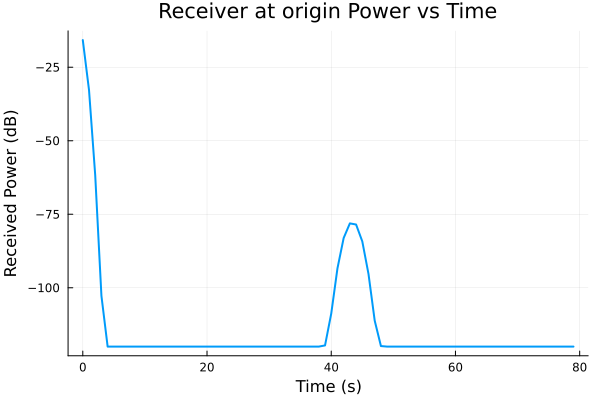

┌ Info: Saved animation to /var/folders/vg/7_0bfbg14lz79gntg6h285yr0000gn/T/jl_YduVMf2zeX.gif
└ @ Plots /Users/carson/.julia/packages/Plots/dIjan/src/animation.jl:156


In [11]:
# --- EXAMPLE SIMULATION ---
x = collect(LinRange(-10000.0, 10000.0, 500))
y = collect(LinRange(-10000.0, 10000.0, 500))
env = RadarEnvironment(x, y)

# Transmitter
tx = PointTransmitter(SVector(0.0, 0.0), 100e9, 100.0, 0.0, 0.6, 45.0, 45.0, false)  # steer straight, 30 degree wedge
add_transmitter!(env, tx)

# Reflector
pos_ref = SVector(5000.0, 5000.0)
snapped_pos_ref = snap_to_grid(env.grid_x, pos_ref)
rx_ref = Reflector(snapped_pos_ref, 0.9, 10^10, false)
add_reflector!(env, rx_ref)

# Receiver (same as transmitter)
pos_rx = SVector(0.0, 0.0)
snapped_pos_rx = snap_to_grid(env.grid_x, pos_rx)
rx = Receiver(snapped_pos_rx, Float64[])
add_receiver!(env, rx)

# Animate
@gif for t = 1:80
    step!(env, 1.0)
    plot_wavefield(env)
end every 2

# --- Run simulation only (NO ANIMATION) ---

# for t = 1:80
#     step!(env, 1.0)
# end

# --- Plot receiver after simulation ---
# println("Receiver power log length = ", length(rx.received_power))

times = collect(0.0:1.0:env.current_time - 1.0)

for rx in env.receivers
    rx_power_db = 10 .* log10.(rx.received_power .+ 1e-12)
    p = plot(times, rx_power_db,
        xlabel = "Time (s)", ylabel = "Received Power (dB)",
        title = "Receiver at origin Power vs Time",
        lw = 2,
        legend = false)

    display(p)  # force plot window (recommended after long simulations)
end